In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1D BCS Reverse RG wavefunctions
$\omega =?$ 
$~~~~~~~~~~~~~~~~~~~~mu=?$

In [2]:
import numpy as np
import re
from numpy import linalg as LA
from time import time
from scipy import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm

__Generating the Fermi surface for the 1D electronic dispersion $\epsilon_{\mathbf{k}}=-2t \cos k_{x}$, Choose $k_x=\pi/2$

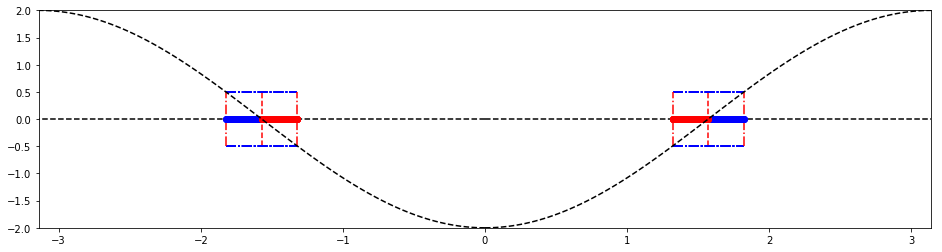

In [3]:
kFx=np.linspace(0,np.pi,100)
kFy=np.zeros(len(kFx))
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(kFx,kFy,'--',color='k')
plt.plot(-kFx,kFy,'--',color='k')



kx_Fermi_point=np.pi/2

ky_Fermi=np.linspace(-0.5,0.5,10)
kx_Fermi=kx_Fermi_point*np.ones(len(ky_Fermi))
plt.plot(kx_Fermi,ky_Fermi,'--',c='r')
plt.plot(-kx_Fermi,ky_Fermi,'--',c='r')


Lambda_kx=0.25   #____________________________   2*Lambda_kx  is the window width
boxheight=2*Lambda_kx

plt.plot(np.linspace(kx_Fermi-Lambda_kx,kx_Fermi+Lambda_kx,10),boxheight*np.ones(10),'-.',c='b')
plt.plot(np.linspace(kx_Fermi-Lambda_kx,kx_Fermi+Lambda_kx,10),-boxheight*np.ones(10),'-.',c='b')
plt.plot((kx_Fermi[0]-Lambda_kx)*np.ones(10),np.linspace(-boxheight,boxheight,10),'-.',c='r')
plt.plot((kx_Fermi[0]+Lambda_kx)*np.ones(10),np.linspace(-boxheight,boxheight,10),'-.',c='r')

plt.plot(np.linspace(-kx_Fermi-Lambda_kx,-kx_Fermi+Lambda_kx,10),boxheight*np.ones(10),'-.',c='b')
plt.plot(np.linspace(-kx_Fermi-Lambda_kx,-kx_Fermi+Lambda_kx,10),-boxheight*np.ones(10),'-.',c='b')
plt.plot((-kx_Fermi[0]-Lambda_kx)*np.ones(10),np.linspace(-boxheight,boxheight,10),'-.',c='r')
plt.plot((-kx_Fermi[0]+Lambda_kx)*np.ones(10),np.linspace(-boxheight,boxheight,10),'-.',c='r')

RGsteps=201#0               #25
LambdaF=(Lambda_kx)*np.linspace(0.0,1.,RGsteps)[1:][::-1]  # Excluding the Fermi point
#print (LambdaF)

Kx_nodes_out=kx_Fermi_point+LambdaF   #np.linspace(kx_Fermi-Lambda_kx,kx_Fermi+Lambda_kx,20)
Kx_nodes_in=kx_Fermi_point-LambdaF   #np.linspace(kx_Fermi-Lambda_kx,kx_Fermi+Lambda_kx,20)
Ky_nodes=np.zeros(len(Kx_nodes_out))

plt.plot(Kx_nodes_out,Ky_nodes,'o',c='b')
plt.plot(-Kx_nodes_out,Ky_nodes,'o',c='b')
plt.plot(Kx_nodes_in,Ky_nodes,'o',c='r')
plt.plot(-Kx_nodes_in,Ky_nodes,'o',c='r')

#____________________________________ t=1
EkOut=-2*np.cos(Kx_nodes_out)
EkIn=-2*np.cos(Kx_nodes_in)
#EkOut
plt.plot(kFx,-2*np.cos(kFx),'--',c='k')
plt.plot(-kFx,-2*np.cos(kFx),'--',c='k')

plt.xlim(-np.pi,np.pi)
plt.ylim(-2,2)

plt.show()

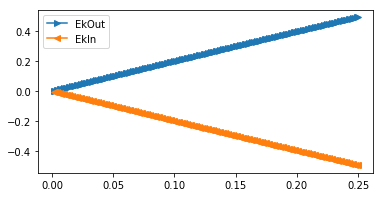

In [4]:
plt.rcParams['figure.figsize'] = [6,3]
plt.plot(LambdaF,EkOut,'>-',label='EkOut')
plt.plot(LambdaF,EkIn,'<-',label='EkIn')
plt.legend()
plt.show()

__Renormalization group equations resulting out of the unitary transformations<br>
1D 

$H=v_F\displaystyle\sum_{\Lambda,\eta=\pm 1} \delta k A^z_{\eta,\delta k}+\frac{U}{2N_{\Lambda}} \vec{A}_{+,\Lambda}.\vec{A}_{-,\Lambda}+\frac{V}{2N_{\Lambda}} \bigg( \vec{A}^2_{+,\Lambda}+\vec{A}^2_{-,\Lambda} \bigg)$ <br><br>

In the $\Downarrow$ sector. In the attractive U case, $U<0$. Back Scattering most relevant thus

$\Delta U^{(j)}=\frac{U^{(j)2}}{\omega-\epsilon_k- \frac{U^{(j)}}{4} }$, $~~~~\omega=0~~,  ~~~\delta k = k - k_F >0.$



# Omega       Bandwidth     Bare Coupling.

In [5]:
omega=0.0
#Bandwith W=8t, t=1
W=4
U0 = W/(RGsteps)

In [6]:
def sign(x):
    if x>0.0:
        return +1
    if x<0.0:
        return -1
    if x==0.0:
        return 0.0

In [7]:
def BS_RG(BS_0):
    invG=-0.5*(EkOut+EkOut)
    BS= 0.0*invG.copy()
    BS[0]=BS_0
    #print ('U0',U0)
    coupling_sign=sign(BS[0])

    ini_sign=sign(invG[0]-BS[0]/4.)    
    #print("initial sign",ini_sign)
    
    for i in range(len(LambdaF)-1):
        BS[i+1] = BS[i] + BS[i]*BS[i]/(invG[i]-BS[i]/4.)	
        #print ('Ts:Disentangled',i+1,'node  ',LambdaF[i+1],L[i],omega-W-mu+EkTan[i])
        #print (L[i])
        if sign(BS[i+1])!=coupling_sign:
            return i+1,LambdaF[i],BS
        
        if (sign(invG[i+1]-BS[i+1]/4.) !=ini_sign) or i==len(LambdaF)-2:
            return i+1,LambdaF[i+1],BS                          #L[i+1],omega-W-mu+EkTan[i]
    

arg1,LambdaStarBs,Bs=BS_RG(-U0)
#print (arg1,'\n',LambdaStarBs,'\n',Bs)

oldBs=Bs.copy()
oldBs[arg1+1:]=np.min(Bs)
newBs=Bs.copy()
newBs[arg1:]=4*(-0.5*(EkOut+EkOut)[arg1])

#print (newBs,'\n','\n',newBs[arg1:])#,arg1)
#print (oldBs)
#print (newBs)


#plt.rcParams['figure.figsize'] = [10,6]
#plt.plot(LambdaF,oldBs,label=r'$Bs_{c}$')
#plt.plot(LambdaF,newBs,label=r'$Bs^{analyt}_{C}$')
#plt.scatter(LambdaF[arg1],newBs[arg1],label=r'$R^{analyt}_{C}/8$')
#plt.legend()
#plt.show()

In [8]:
argBs=arg1
Kc=newBs       # Back Scattering

Vc=np.zeros(len(Kc))       # Forward Scattering

Kc=[Kc]
Vc=[Vc]

                                    11 12 13 14 15 16 17 18 19 20             10  9  8  7  6  5  4  3  2  1

In [9]:
#At this step we are choosing seven points along any normal from 25 points. 
RGIt=10
#LambdaFtrunc=[LambdaF[np.where(LambdaF==LambdaFp)[0][0]-RGIt:np.where(LambdaF==LambdaFp)[0][0]]]
#LambdaF,LambdaF[len(LambdaF)-1-RGIt:len(LambdaF)-1]

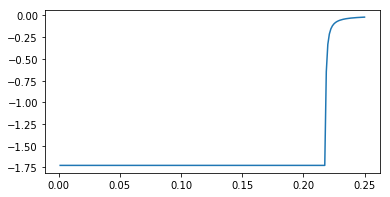

In [10]:
plt.plot(LambdaF,Kc[0])
#plt.plot(LambdaF,Vc[0])
plt.show()
#L[0]

In [11]:
#Choosing 9 IOMs points.
LambdaFtrunc=[]
LambdaFtrunc_Arg=[]
CommonIOMs=LambdaF[0:RGIt-1]
CommonIOMs_arg=np.array(range(0,RGIt-1))

#Choosing only 1 IOMs from those
for t in range(len(CommonIOMs)):
    LambdaFtrunc.append(CommonIOMs[t])
    LambdaFtrunc_Arg.append(CommonIOMs_arg[t])
    
LambdaFtrunc.append(LambdaF[len(LambdaF)-1])
LambdaFtrunc_Arg.append(len(LambdaF)-1)

#LambdaFtrunc
LambdaFtrunc_Arg,LambdaFtrunc
#,LambdaF[0],LambdaF[95]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 199],
 [0.25,
  0.24875,
  0.2475,
  0.24625,
  0.245,
  0.24375,
  0.2425,
  0.24125,
  0.24,
  0.00125])

In [12]:
VcTrunc=np.asarray([Vc[0][arg0]for arg0 in LambdaFtrunc_Arg])
KcTrunc=np.asarray([Kc[0][arg0]for arg0 in LambdaFtrunc_Arg])

EkOut_Trunc=np.asarray([EkOut[arg0]for arg0 in LambdaFtrunc_Arg])
EkIn_Trunc=np.asarray([EkIn[arg0]for arg0 in LambdaFtrunc_Arg])

#VcTrunc,KcTrunc,LTrunc

In [13]:
#We are making an array of ""TWO"" normal directions here
sNormal=np.array([np.pi/2,-np.pi/2])
#number of pseudospins
#No. of normal directions
Ns=len(sNormal)
#As we have chosen Two normal directions therefore N=2k
N=RGIt*Ns#LambdaFMesh.size
#omega,Tc[0]

In [14]:
Psi = open("1D-BCS-wavefunctions/manyBodyWaveFunction28#0.txt","+w")
#Obtaining the ground state wavefunction
#function returns string with array as input
def method(basisState):
    return ''.join([str(num) for num in basisState])
#printing the computational basis states in the file
labels=(''.join([str(num) for num in range(RGIt)]))*len(sNormal)+'\n'+''.join([str(num)*RGIt for num in range(Ns)])+'\n'
Psi.write(labels)
#hole/electron like configurations for the three higher/lower in energy Ioms Lambda0>Lambda1>Lambda2/Lambda3>Lambda4>Lambda5
IomString1='111111111'
IomString0='000000000'
#configurations of pseudospins in emergent space Lambda6 
Conf1=IomString0+'0'+IomString1+'1'
Conf2=IomString0+'1'+IomString1+'0'

Confs=[Conf1,Conf2]
weights=[0.5**0.5,0.5**0.5]
for i in range(len(Confs)):
    Psi.write(Confs[i]+str(weights[i])+"\n")      
Psi.close()


                                 10 11 12 13 14 15 16 17 18  19                  9   8  7  6  5  4  3  2  1  0
                                 1  1  1  1  1  1  1  1  1  (   ----Triplet----   )  0  0  0  0  0  0  0  0  0

In [15]:
list1=[i for i in range(10)]
list2=[i for i in range(10,20)]

pairV=[[i,j] for i in list1 for j in list1 if i<j]+[[i,j] for i in list2 for j in list2 if i<j]+[[i,j] for i in list1 for j in list2 if i<j]

pairK=[[i,j] for i in list1 for j in list1 if i<j]+[[i,j] for i in list2 for j in list2 if i<j]

In [16]:
#ee Green function for the longitudinal scattering processes along normals s_{1} and s_{3}
invG=-0.5*(EkOut+EkOut)
invG=[invG]

def inverseU(Psi,j):
    manyBodyKetGS=np.array([np.array([conf[:N],conf[N:]])for conf in Psi[2:]])

    PsiOld=np.rec.fromarrays([manyBodyKetGS[:,0],manyBodyKetGS[:,1].astype(np.float64)], names='keys,vals')
    Couplings=np.array([np.array([-Vc[0][LambdaFtrunc_Arg[j]]]),np.array([-Kc[0][LambdaFtrunc_Arg[j]]])])

    greenFunc = np.array([np.array([-invG[0][LambdaFtrunc_Arg[j]]-Vc[0][LambdaFtrunc_Arg[j]]]), np.array([invG[0][LambdaFtrunc_Arg[j]]-Kc[0][LambdaFtrunc_Arg[j]]])])
    #indexes of iom's to be re-entangled
    indIoms=[8-j,18-j]
    #print(indIoms)
    #indexes of pseudospins in entangled subspace
    indEnts = list1[::-1][0:j+1]+list2[::-1][0:j+1]
    #print(indEnts)

    #Operation dictionary [pseudospin1,pseudospin2,coeffs] first two entries are the pseuospins to be swapped output is the 
    #is the scatt. coefficient 
    scatOp=lambda m,n: Couplings[1][0]*greenFunc[1][0] if [m,n] in pairK else 0
    #checkOp=lambda m,n: 0 if [m,n] in pairK else pass
    
    
    PsiNew = np.rec.fromarrays([np.zeros(len(PsiOld)*(j+1)*4,dtype='<U32') ,np.zeros(len(PsiOld)*(j+1)*4,dtype=np.float32)], names='keys,vals')
    #putting old confs into new conf
    Nold=len(PsiOld)
    PsiNew['keys'][0:Nold]=PsiOld['keys']
    PsiNew['vals'][0:Nold]=PsiOld['vals']
    swap=lambda conf,a,b:conf[0:a]+conf[b]+conf[a+1:b]+conf[a]+conf[b+1:]
    sgn = lambda iomInd:-1 if PsiOld['keys'][0][iomInd]=='1' else 1
    ###########
    #checkFunc= lambda Nold,PsiNew,conf,modConf,a,b:0 if conf['keys']==modConf else 1 if modConf in PsiNew[0:Nold]['keys'] else 2
    ###########
    supCoeffForConf= lambda Nold,PsiNew,conf,modConf,a,b:PsiNew[0:Nold][np.where(PsiNew[0:Nold]['keys']==modConf)]['vals'] if conf['keys']==modConf else sgn(a)*scatOp(a,b)*conf['vals']+PsiNew[0:Nold][np.where(PsiNew[0:Nold]['keys']==modConf)]['vals'] if modConf in PsiNew[0:Nold]['keys'] else sgn(a)*scatOp(a,b)*conf['vals']
    indFun=lambda modConf,PsiNew,Nold:np.where(PsiNew['keys'][0:Nold]==modConf)[0][0] if modConf in PsiNew[0:Nold]['keys'] else Nold
    for conf in (PsiOld):
        for i in (range(len(indIoms))):
            for j in range(len(indEnts)):
                a=indIoms[i]
                b=indEnts[j]
                #(a,b)=(a,b) if a<b else (b,a)
                if a>b:
                    c=np.array([a]).copy()[0]
                    a=np.array([b]).copy()[0]
                    b=np.array([c]).copy()[0]
                modConf=swap(conf['keys'],a,b)
                ind=indFun(modConf,PsiNew,Nold)
                PsiNew['vals'][ind]=supCoeffForConf(Nold,PsiNew,conf,modConf,a,b)
                #if(conf['keys']!=modConf):
                    #print(a,b,PsiNew['vals'][ind])
                    #print("old conf",conf['keys'])
                    #print("new conf",modConf)
                    #print("scatweight",scatOp(a,b),conf['vals'],'\n')
                PsiNew['keys'][ind]=modConf
                Nold=Nold if ind!=Nold else Nold+1
    PsiNew['vals']=PsiNew['vals']/np.sqrt(np.sum(PsiNew['vals']*PsiNew['vals']))
    #print(PsiNew['keys'].shape,PsiNew['vals'].shape)
    #print((PsiNew['vals']!=-0.0).shape)
    PsiNew=PsiNew[PsiNew['vals']!=0.0]
    return PsiNew[PsiNew['keys']!='']      
    
    


In [17]:
from scipy import sparse
def InnerProd(A,B):
    hashedA = np.array([hash(s) for s in A['keys']])
    hashedB = np.array([hash(s) for s in B['keys']])
    AdjMat=np.equal.outer(hashedB, hashedA)
    SparsedAdjMat=sparse.csr_matrix(AdjMat)
    IP=np.sum(sparse.csr_matrix.dot(sparse.csr_matrix.dot(B['vals'],SparsedAdjMat),A['vals']))
    return IP

#RGIt=5
RGIt

10

In [18]:
t0=time()
for u in tqdm(range(0,RGIt-1)):
#for u in tqdm(range(0,2)):

    Psi=open("1D-BCS-wavefunctions/manyBodyWaveFunction28#%s.txt"%(u),"+r").readlines()
    Tpsi=inverseU(Psi,u)

    PsiN=open("1D-BCS-wavefunctions/manyBodyWaveFunction28#%s.txt"%(u+1),"+w")
    PsiWrite = labels + ''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
    PsiN.write(PsiWrite)
    
    print ('File written:',u+1)#,InnerProd(Tpsi,Tpsi))#,'  Remaining:'(RGIt-1-u),)
    PsiN.close()

tf=time()
print ('Duration taken: ',tf-t0)

  0%|                          | 0/9 [00:00<?, ?it/s]

File written: 1
File written: 2
File written: 3
File written: 4


 44%|████████          | 4/9 [00:00<00:00, 20.01it/s]

File written: 5


 56%|██████████        | 5/9 [00:00<00:00, 13.10it/s]

File written: 6


 67%|████████████      | 6/9 [00:00<00:00,  8.86it/s]

File written: 7


 78%|██████████████    | 7/9 [00:00<00:00,  5.92it/s]

File written: 8


 89%|████████████████  | 8/9 [00:01<00:00,  2.81it/s]

File written: 9


100%|██████████████████| 9/9 [00:02<00:00,  2.12it/s]


Duration taken:  2.384040355682373
